# Updating priors

In this notebook, I will show how it is possible to update the priors as new data becomes available. The example is a slightly modified version of the linear regression in the [Getting started with PyMC3](https://github.com/pymc-devs/pymc3/blob/master/docs/source/notebooks/getting_started.ipynb) notebook.

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from pymc3 import Model, Normal, Slice
from pymc3 import sample
from pymc3 import traceplot
from pymc3.distributions import Continuous
from theano import as_op
import theano.tensor as tt
import numpy as np
from scipy import stats

%matplotlib inline

## Generating data

In [2]:
# Initialize random number generator
np.random.seed(123)

# True parameter values
alpha_true = 5
beta0_true = 7
beta1_true = 13

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha_true + beta0_true * X1 + beta1_true * X2 + np.random.randn(size)

## Model specification

Our initial beliefs about the parameters are quite informative (sd=1) and a bit off the true values.

In [3]:
basic_model = Model()

with basic_model:
    
    # Priors for unknown model parameters
    alpha = Normal('alpha', mu=0, sd=1)
    beta0 = Normal('beta0', mu=12, sd=1)
    beta1 = Normal('beta1', mu=18, sd=1)
    
    # Expected value of outcome
    mu = alpha + beta0 * X1 + beta1 * X2
    
    # Likelihood (sampling distribution) of observations
    Y_obs = Normal('Y_obs', mu=mu, sd=1, observed=Y)
    
    # draw 1000 posterior samples
    trace = sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -178.23: 100%|██████████| 200000/200000 [00:11<00:00, 17384.94it/s]
Finished [100%]: Average ELBO = -178.25
100%|██████████| 1000/1000 [00:01<00:00, 901.60it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f205d9c8400>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f203c71c5f8>]], dtype=object)

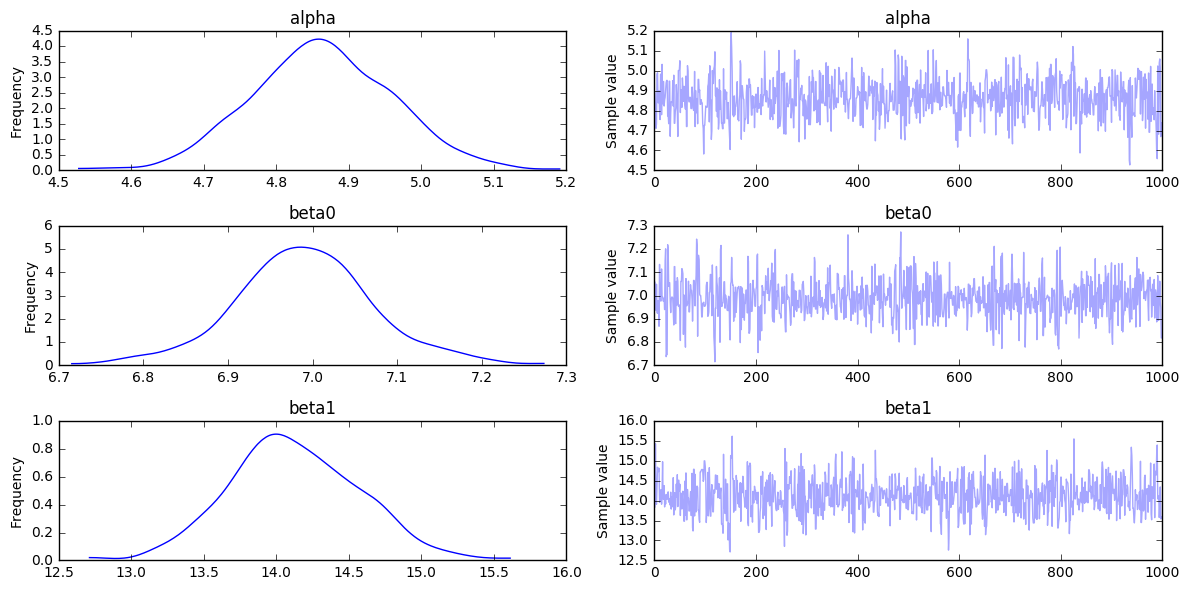

In [4]:
traceplot(trace)

In order to update our beliefs about the parameters, we use the posterior distributions, which will be used as the prior distributions for the next inference. The data used for each inference iteration has to be independent from the previous iterations, otherwise the same (possibly wrong) belief is injected over and over in the system, amplifying the errors and misleading the inference. By ensuring the data is independent, the system should converge to the true parameter values.

Because we draw samples from the posterior distribution (shown on the right in the figure above), we need to estimate their probability density (shown on the left in the figure above). Kernel density estimation (KDE) is a way to achieve this, and we will use this technique here. In any case, it is an empirical distribution that cannot be expressed analytically. Fortunately PyMC3 provides a way to built custom distributions. We just need to inherit the *Continuous* class and provide our own *logp* method. The code below does just that.

In [5]:
def from_posterior(param, samples):

    class From_posterior(Continuous):
        def __init__(self, *args, **kwargs):
            self.from_posterior_logp = _from_posterior_logp()
            super(From_posterior, self).__init__(*args, **kwargs)
        def logp(self, value):
            return self.from_posterior_logp(value)

    def from_posterior_logp(samples):
        smin, smax = np.min(samples), np.max(samples)
        x = np.linspace(smin, smax, 100)
        y = stats.gaussian_kde(samples)(x)
        y0 = np.min(y) / 10 # what was never sampled should have a small probability but not 0
        def _(value):
            return np.array(np.log(np.interp(value, x, y, left=y0, right=y0)))
        return _
    
    from_posterior_logp = from_posterior_logp(samples)

    def _from_posterior_logp():
        @as_op(itypes=[tt.dscalar], otypes=[tt.dscalar])
        def logp(value):
            return from_posterior_logp(value)
        return logp

    return From_posterior(param, testval=np.median(samples))

Now we just need to generate more data and build our Bayesian model so that the prior distributions for the current iteration are the posterior distributions from the previous iteration. The NUTS sampling method cannot be used anymore since it requires to provide the gradient of the distribution, so we will use Slice sampling. We save the posterior samples for each iteration so that we can plot their distribution and see it changing from one iteration to the next (first iterations are plotted in yellow, last iterations are plotted in red).

In [6]:
traces = [trace]

In [15]:
for _ in range(10):

    # generate more data
    X1 = np.random.randn(size)
    X2 = np.random.randn(size) * 0.2
    Y = alpha_true + beta0_true * X1 + beta1_true * X2 + np.random.randn(size)

    model = Model()
    with model:
        burnin = int(len(trace) / 5)

        # Priors are posteriors from previous iteration
        alpha = from_posterior('alpha', trace['alpha'][burnin:])
        beta0 = from_posterior('beta0', trace['beta0'][burnin:])
        beta1 = from_posterior('beta1', trace['beta1'][burnin:])

        # Expected value of outcome
        mu = alpha + beta0 * X1 + beta1 * X2

        # Likelihood (sampling distribution) of observations
        Y_obs = Normal('Y_obs', mu=mu, sd=1, observed=Y)
        
        step = Slice([alpha, beta0, beta1])
        
        # draw 1000 posterior samples
        trace = sample(1000, step=step)
        traces.append(trace)

100%|██████████| 1000/1000 [00:03<00:00, 326.96it/s]


Posterior distributions after 51 iterations.


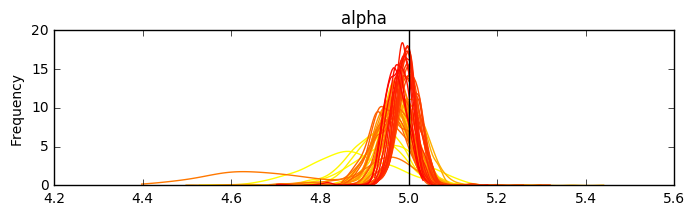

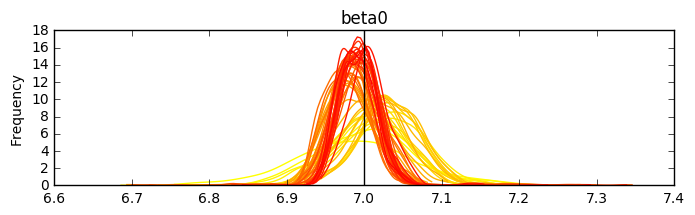

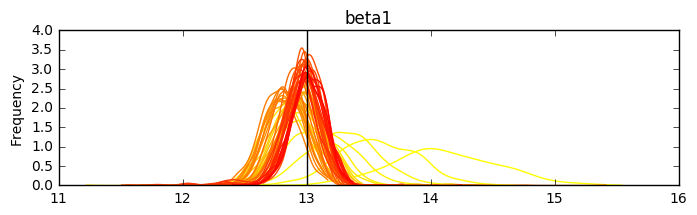

In [16]:
print('Posterior distributions after ' + str(len(traces)) + ' iterations.')
cmap = mpl.cm.autumn
for param in ['alpha', 'beta0', 'beta1']:
    plt.figure(figsize=(8, 2))
    for update_i, trace in enumerate(traces):
        samples = trace[param][burnin:]
        smin, smax = np.min(samples), np.max(samples)
        x = np.linspace(smin, smax, 100)
        y = stats.gaussian_kde(samples)(x)
        plt.plot(x, y, color=cmap(1 - update_i / len(traces)))
    plt.axvline({'alpha': alpha_true, 'beta0': beta0_true, 'beta1': beta1_true}[param], c='k')
    plt.ylabel('Frequency')
    plt.title(param)
    plt.show()

You can re-execute the last two cells to generate more updates.

What is interesting to note is that the posterior distributions for our parameters tend to get centered on their true value (vertical lines), and the distribution gets thiner and thiner. This means that we get more confident each time, and the (false) belief we had at the beginning gets flushed away by the new data we incorporate.